In [1]:
nevecs = 60
ncomps = 500
nbasecomps = 20
crop_size=180
ncauses = 2
dr_method = 'KPCA'

In [2]:
from pathlib import Path
import os, sys

In [3]:

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

exp_name = 'near_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/'no_bias'/'train'

# test_csv_path = macaw_path/'data'/'ukbb'/'test_hc.csv'
# test_img_path = macaw_path/'data'/'ukbb'/'axial'/'test_hc'
# 
kpca_path = macaw_path/exp_name/f'train_hc_kpca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_KPCA_{ncomps}.pkl'
# test_path = macaw_path/'data'/'ukbb'/'axial'/f'test_hc_data_KPCA_{ncomps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{ncomps}'/f'{nevecs}'

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path)

In [4]:
import pickle

with open(train_path, 'rb') as f:
    train = pickle.load(f)
    
disease = train['disease']
bias = train['bias']

encoded_data = train['encoded_data']
kpca = train['kpca']

In [5]:
encoded_data.shape

(1005, 500)

In [6]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    age+=min_age
    
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    imgs = kpca.inverse_transform(latent_enc)
    return age,bmi,imgs

[Text(0.5, 1.0, 'disease')]

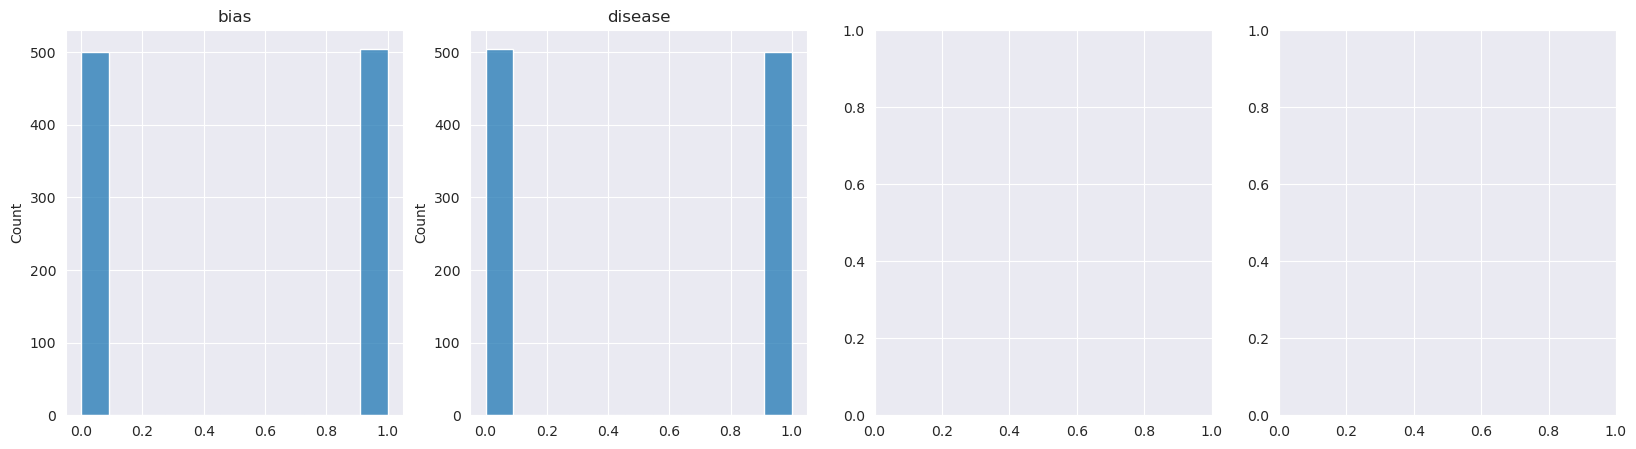

In [7]:
import seaborn as sns

sb = 4
fig, axs = plt.subplots(1,sb, figsize=(sb*5,5))

sns.histplot(bias,ax=axs[0],fill=True)
axs[0].set(title = "bias")
sns.histplot(disease,ax=axs[1], fill=True)
axs[1].set(title="disease")
# sns.histplot(encoded_data[0],ax=axs[3], fill=True)
# axs[3].set(title="PCA0")

In [8]:
# import utils.visualize as vis
# 
# plt.rcParams['figure.figsize'] = (20,4)
# nsamples = 5
# 
# idx = np.random.randint(0,disease.shape[0],nsamples)
# re = recons(disease[idx],bias[idx],encoded_data[idx])
# 
# sex_t = ['Male' if round(s) else 'Female' for s in disease[idx]]
# titles_sam = [f'Sex:{s}, Age:{a}, BMI:{np.round(b)}' for s,a,b in zip(sex_t, re[0],re[1])]
# fig  = vis.img_grid([i.reshape(crop_size,crop_size).T for i in re[2]],cols=nsamples,titles=titles_sam)

## Causal Graph

In [9]:
disease_to_latents = [(0,i) for i in range(ncauses,nevecs+ncauses)]

bias_to_latents = [(1,i) for i in range(ncauses,nevecs+ncauses)]

autoregressive_latents = [(i,j) for i in range(ncauses,nevecs+ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = [(i,j) for i in range(ncauses,2*ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = []
edges = disease_to_latents + bias_to_latents + autoregressive_latents

## Priors

In [10]:
P_bias = np.sum(bias)/len(bias)
print(P_bias)

P_dis = np.sum(disease)/len(disease)
print(P_dis)

0.5024875621890548
0.4975124378109453


In [11]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
import torch.distributions as td

dev='cpu'

priors = [(slice(0,1),td.Bernoulli(torch.tensor([P_bias]).to(torch.device(dev)))), # bias
          (slice(1,2),td.Bernoulli(torch.tensor([P_dis]).to(torch.device(dev)))), # disease
          (slice(nbasecomps+2,nevecs+2),td.Normal(torch.zeros(nevecs-nbasecomps).to(torch.device(dev)), torch.ones(nevecs-nbasecomps).to(torch.device(dev)))), # new_comps
         ]

In [13]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

2024-05-22 15:31:36.916328: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 15:31:36.917589: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 15:31:36.946029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 15:31:37.432904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
loss_vals = []

In [15]:
from macaw import MACAW

for e in range(0,479,nevecs-nbasecomps):
    save_path = model_base_path/f'{e}.pt'    
    ed =  encoded_data[:,e:e+nevecs]
    print(e,e+nevecs)
    
    if not os.path.exists(save_path): 
       
        X = np.hstack([bias[:,np.newaxis], disease[:,np.newaxis], ed])    

        macaw = MACAW.MACAW(config)
        loss_vals.append(macaw.fit_with_priors(X,edges, priors))

        torch.save(macaw,save_path)
    else:
        print("Skipping")

0 60


/home/volatope/Software/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/30 [00:00<?, ?it/s]

40 100


  0%|          | 0/30 [00:00<?, ?it/s]

80 140


  0%|          | 0/30 [00:00<?, ?it/s]

120 180


  0%|          | 0/30 [00:00<?, ?it/s]

160 220


  0%|          | 0/30 [00:00<?, ?it/s]

200 260


  0%|          | 0/30 [00:00<?, ?it/s]

240 300


  0%|          | 0/30 [00:00<?, ?it/s]

280 340


  0%|          | 0/30 [00:00<?, ?it/s]

320 380


  0%|          | 0/30 [00:00<?, ?it/s]

360 420


  0%|          | 0/30 [00:00<?, ?it/s]

400 460


  0%|          | 0/30 [00:00<?, ?it/s]

440 500


  0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
loss_vals

[([9541.84557062785,
   -2640.835909016927,
   -4997.6735432942705,
   -10608.050813802083,
   -23986.38466796875,
   -5206.049645996094,
   2310.5653483072915,
   2310.565323893229,
   2310.5653869628904,
   2310.565291341146,
   2310.565311686198,
   2310.565301513672,
   2310.565352376302,
   2310.5653279622397,
   2310.5653096516926,
   2310.565329996745,
   2310.565358479818,
   2310.5653442382813,
   2310.5653727213544,
   2310.5653727213544,
   2310.5653483072915,
   2310.565334065755,
   2310.5653076171875,
   2310.565334065755,
   2310.565321858724,
   2310.5653157552083,
   2310.5653686523438,
   2310.565311686198,
   2310.565321858724,
   2310.565362548828],
  [-1094.4076843261719,
   -3175.121826171875,
   -6304.594970703125,
   -14178.67919921875,
   -40257.328125,
   1936.35302734375,
   1936.3530883789062,
   1936.35302734375,
   1936.3532104492188,
   1936.3531494140625,
   1936.3530883789062,
   1936.3530883789062,
   1936.35302734375,
   1936.35302734375,
   1936.3529

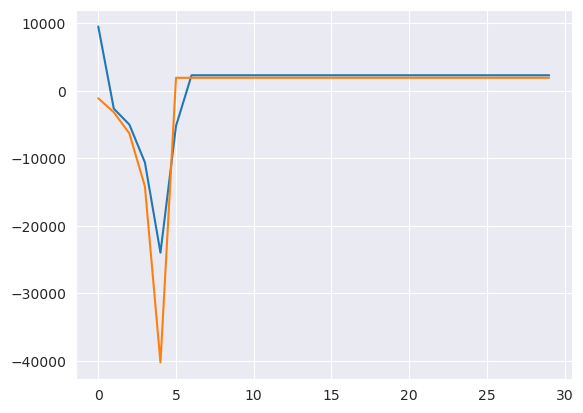

In [17]:
plt.plot(np.array(loss_vals[0][0]))
plt.plot(np.array(loss_vals[0][1]))

In [18]:
model_path = model_base_path/'hyperparameters.pkl'

with open(model_path, 'wb') as f:
    pickle.dump({'ncomps':ncomps, 'nevecs':nevecs,'nbasecomps':nbasecomps, 'ncauses':ncauses, 'crop_size':crop_size}, f)

## Linear regression

In [19]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
ed =  encoded_data[:,:nevecs]
X = np.hstack([sex[:,np.newaxis], bmi[:,np.newaxis], ed])    

NameError: name 'sex' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, age)

In [ ]:
reg.score(X, age)

In [ ]:
lr_path = model_base_path/'lr.pkl'

with open(lr_path, 'wb') as f:
    pickle.dump({'reg':reg}, f)

In [ ]:
lr_path

In [ ]:
reg.coef_

In [ ]:
np.mean(np.abs(reg.predict(X) - age))

In [ ]:
idx = 0
macaw = torch.load(model_base_path/f'{idx}.pt')
X_test = np.hstack([sex[:,np.newaxis], age[:,np.newaxis], bmi[:,np.newaxis], encoded_data[:,idx:nevecs+idx]])

In [ ]:
encoded_data.shape

In [ ]:
probs=[]
for i in range(36):
    X_test[:,1] = i
    probs.append(macaw.log_likelihood(X_test))

In [ ]:
pexp = np.exp(np.array(probs))
pexp_sum = np.sum(pexp,axis=0)
p = pexp/pexp_sum

In [ ]:
pred_labels = np.argmax(probs, axis=0)

In [ ]:
age_bins=36

In [ ]:
sns.histplot(age, bins=age_bins)
sns.histplot(pred_labels,bins=age_bins)

In [ ]:
l = np.array(probs)[:,80]
plt.bar(np.arange(36),l-np.min(l))

In [ ]:
sns.histplot(age-pred_labels, bins=age_bins)

In [ ]:
np.mean(np.abs(pred_labels - age))